=== QA (Before) ===


,Tahap,Indikator,Deskripsi,Nilai
0,before,Missing MMSI (%),Persen MMSI hilang,0.0000
1,before,Missing dt_pos_utc (%),Persen waktu posisi hilang,0.0000
2,before,Missing Koordinat (%),Rata-rata missing latitude & longitude,0.0000
3,before,Missing SOG (%),Persen SOG hilang,0.0000
4,before,MMSI Tidak Valid (%),"Di luar 9-digit (100,000,000–999,999,999)",0.0000
5,before,Draught = 0 (%),Proporsi draught nol,NaN
6,before,Draught Missing (%),Proporsi draught hilang,NaN
7,before,Schema Range Pass Rate (%),lat/lon/sog dalam rentang wajar,100.0000
8,before,Jumlah Rekor,Total records,100.0000
9,before,Jumlah MMSI Unik,Kapal unik (MMSI),4.0000


=== QA (After) ===


,Tahap,Indikator,Deskripsi,Nilai
0,after,Missing MMSI (%),Persen MMSI hilang,0.0000
1,after,Missing dt_pos_utc (%),Persen waktu posisi hilang,0.0000
2,after,Missing Koordinat (%),Rata-rata missing latitude & longitude,0.0000
3,after,Missing SOG (%),Persen SOG hilang,0.0000
4,after,MMSI Tidak Valid (%),"Di luar 9-digit (100,000,000–999,999,999)",0.0000
5,after,Draught = 0 (%),Proporsi draught nol,NaN
6,after,Draught Missing (%),Proporsi draught hilang,NaN
7,after,Schema Range Pass Rate (%),lat/lon/sog dalam rentang wajar,100.0000
8,after,Jumlah Rekor,Total records,100.0000
9,after,Jumlah MMSI Unik,Kapal unik (MMSI),4.0000


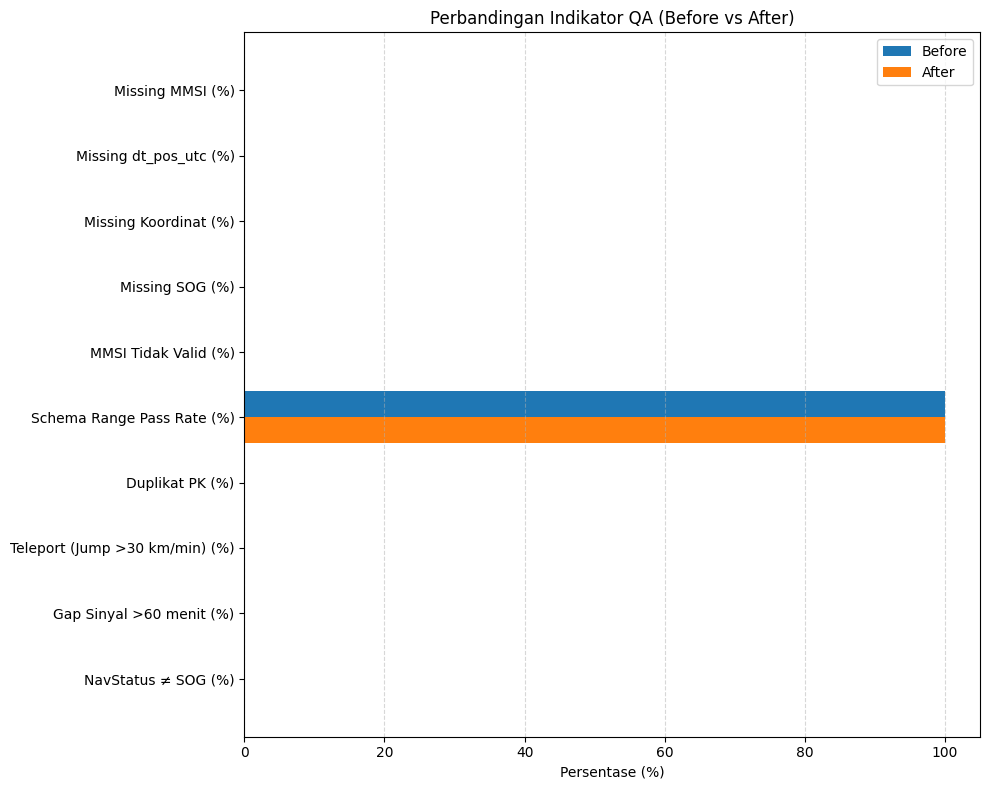

In [ ]:
# =========================================================
# AIS CSV Pipeline — Preprocessing + QA
# - Input: file CSV AIS
# - Output: data bersih + metrik kualitas + grafik before/after
# - Roust: kalau ada kolom hilang/format aneh, kode tetap jalan
# =========================================================

# 0) Import & install kalau perlu
import sys, subprocess

def pip_install(pkg: str):
    out = subprocess.run([sys.executable, "-m", "pip", "install", pkg],
                         capture_output=True, text=True)
    print(out.stdout or out.stderr)

for p in ["pandas", "numpy", "matplotlib"]:
    try:
        __import__(p)
    except ImportError:
        pip_install(p)

# opsional (nggak wajib, cuma kalau pakai nanti)
for p in ["h3", "shapely", "pyogrio", "geopandas"]:
    try:
        __import__(p if p != "pyogrio" else "pyogrio")
    except Exception:
        pass

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from typing import Optional, List, Dict

# 1) Kolom standar + loader CSV
DEFAULT_COLUMNS = [
    # identitas
    "mmsi","imo","vessel_name","callsign","flag_country","vessel_type",
    # waktu & lokasi
    "dt_insert_utc","dt_pos_utc","latitude","longitude",
    # dinamika
    "sog","cog","heading","nav_status",
    # fisik
    "Draught","length","width",
    # H3 (kalau ada di CSV)
    "H3_int_index_7",
    # opsional
    "message_type",
]

def load_ais_csv(path: str, columns: Optional[List[str]] = None) -> pd.DataFrame:
    """Baca CSV; kalau 'columns' diisi, ambil hanya kolom yang tersedia."""
    df = pd.read_csv(path)
    if columns:
        cols = [c for c in columns if c in df.columns]
        df = df[cols]
    return df

def rename_to_snake_pandas(df: pd.DataFrame) -> pd.DataFrame:
    """Rapikan nama kolom: huruf kecil + underscore (biar konsisten)."""
    std = lambda s: s.strip().lower().replace(" ", "_")
    return df.rename(columns={c: std(c) for c in df.columns})

# 2) Fungsi bantu (waktu & jarak)
def _safe_tz_utc_series(s: pd.Series) -> pd.Series:
    """Pastikan kolom waktu jadi datetime UTC (nggak error walau datanya liar)."""
    s = pd.to_datetime(s, errors="coerce")
    try:
        if s.dt.tz is None:
            return s.dt.tz_localize("UTC")
        return s.dt.tz_convert("UTC")
    except Exception:
        return pd.to_datetime(s, errors="coerce").dt.tz_localize("UTC")

def _haversine_series(lat1, lon1, lat2, lon2) -> pd.Series:
    """Hitung jarak km antar titik (pakai rumus haversine), versi vectorized."""
    r = 6371.0
    lat1 = np.radians(pd.to_numeric(lat1, errors="coerce").astype(float))
    lat2 = np.radians(pd.to_numeric(lat2, errors="coerce").astype(float))
    lon1 = np.radians(pd.to_numeric(lon1, errors="coerce").astype(float))
    lon2 = np.radians(pd.to_numeric(lon2, errors="coerce").astype(float))
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2.0 * r * np.arcsin(np.sqrt(a))

def _safe_div(num: np.ndarray, den: np.ndarray) -> np.ndarray:
    """Bagi ‘aman’: kalau nol/NaN → hasilnya NaN (nggak bikin crash)."""
    out = np.divide(num, den, out=np.full_like(num, np.nan, dtype="float64"),
                    where=~(np.isnan(den) | (den == 0)))
    out[~np.isfinite(out)] = np.nan
    return out

# 3) Preprocessing (bisa di-ON/OFF via parameter)
def preprocess_ais_pandas(
    df: pd.DataFrame,
    *,
    drop_missing=True,        # buang baris yang kolom kunci-nya kosong
    drop_invalid_mmsi=True,   # MMSI harus 9 digit
    drop_coord_outlier=True,  # filter koordinat aneh
    drop_sog_outlier=True,    # filter SOG aneh
    impute_imo=True,          # isi IMO kosong pakai value kapal yang sama
    deduplicate=True,         # hapus duplikat
    filter_draught=True,      # buang draught 0
    filter_vessel_type=False, # kalau True: hanya Cargo/Tanker
    filter_future_time=True,  # buang timestamp “masa depan”
    filter_teleport=True,     # buang loncatan posisi nggak masuk akal
    filter_gap=True,          # buang jeda ping > 60 menit
    audit_metadata=True,      # cek metadata kapal yang gonta-ganti
    add_inside_port=True,     # tambahkan kolom dummy inside_port (draught>5)
):
    df = df.copy()

    # standarkan waktu ke UTC
    for col in ["dt_pos_utc", "dt_insert_utc"]:
        if col in df:
            df[col] = _safe_tz_utc_series(df[col])

    # buang baris kalau kolom kunci kosong
    if drop_missing:
        need = [c for c in ["mmsi","dt_pos_utc","latitude","longitude","sog"] if c in df.columns]
        if need:
            df = df.dropna(subset=need)

    # MMSI valid (9 digit)
    if drop_invalid_mmsi and "mmsi" in df:
        m = pd.to_numeric(df["mmsi"], errors="coerce")
        df = df[m.between(100_000_000, 999_999_999)]

    # koordinat & SOG masuk akal
    if drop_coord_outlier and {"latitude","longitude"} <= set(df.columns):
        df = df[df["latitude"].between(-90,90) & df["longitude"].between(-180,180)]
    if drop_sog_outlier and "sog" in df:
        df = df[df["sog"].between(0,70)]

    # isi IMO kosong pakai nilai sebelumnya/berikutnya di MMSI yang sama
    if impute_imo and {"mmsi","imo"} <= set(df.columns):
        df["imo"] = df.groupby("mmsi")["imo"].transform(lambda s: s.ffill().bfill())

    # hapus duplikat (kalau ada message_type, pakai sekalian)
    if deduplicate:
        key = [c for c in ["mmsi","dt_pos_utc","message_type"] if c in df.columns]
        if key:
            df = df.drop_duplicates(subset=key)

    # filter draught dan tipe kapal (opsional)
    if filter_draught and "draught" in df:
        df = df[df["draught"].notna() & (df["draught"] > 0)]
    if filter_vessel_type and "vessel_type" in df:
        df = df[df["vessel_type"].astype(str).str.upper().isin(["CARGO","TANKER"])]

    # waktu masa depan (kasih toleransi 5 menit)
    if filter_future_time and "dt_pos_utc" in df:
        df = df[df["dt_pos_utc"] <= pd.Timestamp.now(tz="UTC") + pd.Timedelta(minutes=5)]

    # hitung loncatan & gap waktu, plus kecepatan hasil hitung (sog_calc)
    if {"mmsi","dt_pos_utc","latitude","longitude"} <= set(df.columns):
        df = df.sort_values(["mmsi","dt_pos_utc"])
        df["prev_lat"]  = df.groupby("mmsi")["latitude"].shift()
        df["prev_lon"]  = df.groupby("mmsi")["longitude"].shift()
        df["prev_time"] = df.groupby("mmsi")["dt_pos_utc"].shift()

        jump_km = _haversine_series(df["prev_lat"],df["prev_lon"],df["latitude"],df["longitude"])
        dt_min  = (df["dt_pos_utc"] - df["prev_time"]).dt.total_seconds() / 60.0

        df["km_per_min"] = _safe_div(jump_km.to_numpy(dtype="float64"),
                                     pd.to_numeric(dt_min, errors="coerce").to_numpy(dtype="float64"))
        if filter_teleport:
            df = df[~(df["km_per_min"] > 30.0)]
        if filter_gap:
            df = df[~(dt_min > 60.0)]

        df["sog_calc"] = _safe_div(jump_km.to_numpy(dtype="float64"),
                                   (pd.to_numeric(dt_min, errors="coerce")/60.0).to_numpy(dtype="float64"))

    # tambahkan indikator inside_port (proxy sederhana)
    if add_inside_port and "draught" in df:
        df["inside_port"] = df["draught"] > 5

    # audit metadata kapal (apakah gonta-ganti IMO/nama/ukuran di MMSI sama)
    meta_inconsistent = None
    need_meta = {"mmsi","imo","vessel_name","length","width"}
    if audit_metadata and need_meta <= set(df.columns):
        meta_flags = df.groupby("mmsi")[["imo","vessel_name","length","width"]].nunique(dropna=True)
        meta_inconsistent = meta_flags[(meta_flags > 1).any(axis=1)]

    return df.reset_index(drop=True), meta_inconsistent

# 4) Laporan QA (lengkap)
def qa_metrics_pandas(df: pd.DataFrame, *, stage: str = "raw") -> pd.DataFrame:
    """
    Bikin tabel QA lengkap: missing, validasi skema, p95 latency,
    teleport/gap, beda SOG vs perhitungan, nav_status vs SOG, konflik metadata, dll.
    """
    rows = []
    def add(name, desc, val):
        rows.append({"Tahap": stage, "Indikator": name, "Deskripsi": desc, "Nilai": val})

    # siapkan kolom waktu (tanpa ganggu data asli)
    dtp = pd.to_datetime(df["dt_pos_utc"], errors="coerce") if "dt_pos_utc" in df else pd.Series(pd.NaT, index=df.index)
    dti = pd.to_datetime(df["dt_insert_utc"], errors="coerce") if "dt_insert_utc" in df else pd.Series(pd.NaT, index=df.index)

    # missing & cek dasar
    add("Missing MMSI (%)", "Persen MMSI hilang", df["mmsi"].isna().mean()*100 if "mmsi" in df else np.nan)
    add("Missing dt_pos_utc (%)", "Persen waktu posisi hilang", dtp.isna().mean()*100 if len(dtp) else np.nan)
    if {"latitude","longitude"} <= set(df.columns):
        add("Missing Koordinat (%)", "Rata-rata missing latitude & longitude", df[["latitude","longitude"]].isna().mean().mean()*100)
    else:
        add("Missing Koordinat (%)", "Rata-rata missing latitude & longitude", np.nan)
    add("Missing SOG (%)", "Persen SOG hilang", df["sog"].isna().mean()*100 if "sog" in df else np.nan)

    # MMSI valid 9 digit
    if "mmsi" in df:
        m = pd.to_numeric(df["mmsi"], errors="coerce")
        add("MMSI Tidak Valid (%)", "Di luar 9-digit (100,000,000–999,999,999)", (~m.between(100_000_000, 999_999_999)).mean()*100)
    else:
        add("MMSI Tidak Valid (%)", "Di luar 9-digit", np.nan)

    # draught summary
    if "draught" in df:
        add("Draught = 0 (%)", "Proporsi draught nol", (df["draught"].fillna(0) == 0).mean()*100)
        add("Draught Missing (%)", "Proporsi draught hilang", df["draught"].isna().mean()*100)
    else:
        add("Draught = 0 (%)", "Proporsi draught nol", np.nan)
        add("Draught Missing (%)", "Proporsi draught hilang", np.nan)

    # cek rentang wajar lat/lon/sog
    if {"latitude","longitude","sog"} <= set(df.columns):
        mask = df["latitude"].between(-90,90) & df["longitude"].between(-180,180) & df["sog"].between(0,70)
        add("Schema Range Pass Rate (%)", "lat/lon/sog dalam rentang wajar", mask.mean()*100)
    else:
        add("Schema Range Pass Rate (%)", "lat/lon/sog dalam rentang wajar", np.nan)

    # ukuran dataset & kepadatan per MMSI
    add("Jumlah Rekor", "Total records", len(df))
    n_mmsi = df["mmsi"].nunique() if "mmsi" in df else np.nan
    add("Jumlah MMSI Unik", "Kapal unik (MMSI)", n_mmsi)
    add("Rata-rata Ping per MMSI", "Records/kapal rata-rata", (len(df)/max(1, n_mmsi)) if pd.notna(n_mmsi) else np.nan)

    # sebaran hari (Senin–Minggu)
    if pd.api.types.is_datetime64_any_dtype(dtp):
        weekday_counts = dtp.dt.day_name().value_counts(dropna=False)
        for k, v in weekday_counts.items():
            add(f"Weekday {k} (count)", "Jumlah ping pada hari tersebut", int(v))

    # cakupan H3 (kalau ada)
    if "h3_int_index_7" in df:
        add("Cakupan Sel H3 (res7)", "Jumlah sel H3 unik (res7)", df["h3_int_index_7"].nunique())

    # proporsi titik di pelabuhan (proxy)
    if "inside_port" in df:
        add("Inside-Port Share (%)", "Proporsi titik di pelabuhan (proxy draught>5)", df["inside_port"].mean()*100)

    # duplikat kunci (mmsi,waktu)
    if {"mmsi","dt_pos_utc"} <= set(df.columns):
        dup = df.duplicated(subset=["mmsi","dt_pos_utc"], keep=False)
        add("Duplikat PK (%)", "Persen baris dengan (mmsi, dt_pos_utc) ganda", dup.mean()*100)
    else:
        add("Duplikat PK (%)", "Persen baris PK ganda", np.nan)

    # p95 latency (selisih insert vs posisi)
    if len(dtp) and len(dti):
        try:
            dti_utc = _safe_tz_utc_series(dti); dtp_utc = _safe_tz_utc_series(dtp)
            latency = (dti_utc - dtp_utc).dt.total_seconds()
            add("Ingest Latency p95 (detik)", "P95 dt_insert_utc - dt_pos_utc", float(np.nanpercentile(latency, 95)) if latency.notna().any() else np.nan)
        except Exception:
            add("Ingest Latency p95 (detik)", "P95 dt_insert_utc - dt_pos_utc", np.nan)
    else:
        add("Ingest Latency p95 (detik)", "P95 dt_insert_utc - dt_pos_utc", np.nan)

    # teleport/gap + perbandingan SOG vs hasil hitung
    if {"mmsi","dt_pos_utc","latitude","longitude"} <= set(df.columns):
        tmp = df.loc[:, [c for c in ["mmsi","dt_pos_utc","latitude","longitude","sog"] if c in df.columns]].copy()
        tmp["dt_pos_utc"] = _safe_tz_utc_series(tmp["dt_pos_utc"])
        tmp = tmp.sort_values(["mmsi","dt_pos_utc"])
        tmp["prev_lat"] = tmp.groupby("mmsi")["latitude"].shift()
        tmp["prev_lon"] = tmp.groupby("mmsi")["longitude"].shift()
        tmp["prev_time"] = tmp.groupby("mmsi")["dt_pos_utc"].shift()

        jump_km = _haversine_series(tmp["prev_lat"], tmp["prev_lon"], tmp["latitude"], tmp["longitude"])
        dt_min  = (tmp["dt_pos_utc"] - tmp["prev_time"]).dt.total_seconds() / 60.0
        km_per_min = _safe_div(jump_km.to_numpy(dtype="float64"), dt_min.to_numpy(dtype="float64"))
        gap_flag  = (dt_min > 60.0)

        add("Teleport (Jump >30 km/min) (%)", "Loncatan spasial tak wajar", np.nanmean((km_per_min > 30.0).astype(float))*100 if len(km_per_min) else np.nan)
        add("Gap Sinyal >60 menit (%)", "Jeda antar ping terlalu lama", np.nanmean(gap_flag.astype(float))*100 if len(gap_flag) else np.nan)

        if "sog" in tmp:
            sog_calc = _safe_div(jump_km.to_numpy(dtype="float64"), (dt_min/60.0).to_numpy(dtype="float64"))
            sog = pd.to_numeric(tmp["sog"], errors="coerce").to_numpy(dtype="float64")
            speed_gap = np.abs(sog - sog_calc)
            add("Gap SOG vs Perhitungan (mean)", "Rata-rata |SOG - SOG_calc| (km/jam)", float(np.nanmean(speed_gap)) if np.isfinite(speed_gap).any() else np.nan)
        else:
            add("Gap SOG vs Perhitungan (mean)", "Rata-rata |SOG - SOG_calc|", np.nan)
    else:
        add("Teleport (Jump >30 km/min) (%)", "Loncatan spasial", np.nan)
        add("Gap Sinyal >60 menit (%)", "Jeda ping", np.nan)
        add("Gap SOG vs Perhitungan (mean)", "Rata-rata |SOG - SOG_calc|", np.nan)

    # cek logika nav_status vs SOG
    if {"nav_status","sog"} <= set(df.columns):
        incoh = df["nav_status"].astype(str).str.contains("Moored|Anchored", case=False, na=False) & (df["sog"] > 0.5)
        add("NavStatus ≠ SOG (%)", "Moored/Anchored tetapi SOG > 0.5", incoh.mean()*100)
    else:
        add("NavStatus ≠ SOG (%)", "Moored/Anchored tetapi SOG > 0.5", np.nan)

    # hitung jumlah MMSI yang metadata-nya nggak konsisten
    if {"mmsi","imo","vessel_name","length","width"} <= set(df.columns):
        meta_var = df.groupby("mmsi")[["imo","vessel_name","length","width"]].nunique(dropna=True)
        conflict_count = int((meta_var > 1).any(axis=1).sum())
        add("Konflik Metadata Kapal (MMSI count)", "MMSI dengan variasi metadata >1", conflict_count)
    else:
        add("Konflik Metadata Kapal (MMSI count)", "MMSI dengan variasi metadata >1", np.nan)

    return pd.DataFrame(rows)

# 5) Plot perbandingan before vs after (hanya indikator %)
def plot_qa_before_after(qa_before: pd.DataFrame, qa_after: pd.DataFrame, *, top_n: int = 15):
    qa_all = pd.concat([qa_before, qa_after], ignore_index=True)
    mask_pct = qa_all["Indikator"].str.contains(r"%|rate|Rate|share|Share|proporsi|Proporsi", regex=True, na=False)
    plot_df = qa_all[mask_pct & qa_all["Nilai"].notna()].copy()
    if plot_df.empty:
        print(">> Nggak ada indikator persentase yang bisa diplot.")
        return

    top_inds = (plot_df[plot_df["Tahap"]=="before"]
                .sort_values("Nilai", ascending=False)
                .head(top_n)["Indikator"].tolist())
    plot_sub = plot_df[plot_df["Indikator"].isin(top_inds)]
    before_vals = plot_sub[plot_sub["Tahap"]=="before"].set_index("Indikator")["Nilai"]
    after_vals  = plot_sub[plot_sub["Tahap"]=="after"].set_index("Indikator")["Nilai"]

    inds = before_vals.index.tolist()
    y = np.arange(len(inds)); width = 0.4
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(y - width/2, before_vals.reindex(inds).values, height=width, label="Before")
    ax.barh(y + width/2, after_vals.reindex(inds).values,  height=width, label="After")
    ax.set_yticks(y, inds); ax.invert_yaxis()
    ax.set_xlabel("Persentase (%)"); ax.set_title("Perbandingan Indikator QA (Before vs After)")
    ax.grid(axis='x', linestyle='--', alpha=0.5); ax.legend()
    plt.tight_layout(); plt.show()

# 6) Contoh jalanin (ganti path sesuai file)
CSV_PATH = "sample_ais_data.csv"

# load → rapikan kolom → QA awal
df_raw = load_ais_csv(CSV_PATH, columns=DEFAULT_COLUMNS)
df_raw = rename_to_snake_pandas(df_raw)
qa_before = qa_metrics_pandas(df_raw, stage="before")

# setelan langkah (bebas diubah)
steps: Dict = dict(
    drop_missing=True,
    drop_invalid_mmsi=True,
    drop_coord_outlier=True,
    drop_sog_outlier=True,
    impute_imo=True,
    deduplicate=True,
    filter_draught=True,
    filter_vessel_type=False,
    filter_future_time=True,
    filter_teleport=True,
    filter_gap=True,
    audit_metadata=True,
    add_inside_port=True,
)

# preprocess → QA sesudah → tampilkan + plot
df_clean, meta_inconsistent = preprocess_ais_pandas(df_raw, **steps)
qa_after = qa_metrics_pandas(df_clean, stage="after")

print("=== QA (Before) ==="); display(qa_before.head(20))
print("=== QA (After) ===");  display(qa_after.head(20))
plot_qa_before_after(qa_before, qa_after, top_n=15)

# kalau ada MMSI yang metadata-nya rancu, tampilkan contoh
if meta_inconsistent is not None and not meta_inconsistent.empty:
    print("MMSI dengan metadata inkonsisten (contoh 10 baris):")
    display(meta_inconsistent.head(10))
